In [71]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push

!pip install -Uqq fastbook
from fastai.collab import *
from fastai.tabular.all import *

# !pip install --upgrade --force-reinstall --no-deps kaggle
!pip install kaggle
creds = '{"username":"hwangintaek","key":"b69250298bc0f761edd8510a4d133575"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.mk_write(creds)
    cred_path.chmod(0o600)
import kaggle

In [72]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [73]:
import os

def file_extract(fname, dest=None):
     "Extract `fname` to `dest` using `tarfile` or `zipfile`."
     if dest is None: dest = Path(fname).parent
     fname = str(fname)
     if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
     elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
     else: raise Exception(f'Unrecognized archive: {fname}')

if not path.exists():
    os.makedirs(path)
    kaggle.api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

(#7) [Path('/root/.fastai/archive/bluebook/Valid.csv'),Path('/root/.fastai/archive/bluebook/Machine_Appendix.csv'),Path('/root/.fastai/archive/bluebook/random_forest_benchmark_test.csv'),Path('/root/.fastai/archive/bluebook/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook/Test.csv'),Path('/root/.fastai/archive/bluebook/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook/TrainAndValid.csv')]

In [74]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [75]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [76]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True)

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [77]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [78]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [79]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [80]:
procs = [Categorify, FillMissing]

In [81]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
print(train_idx)
print(valid_idx)

[     0      1      2 ... 412695 412696 412697]
[ 22915  22916  22917 ... 401122 401123 401124]


In [82]:
splits = (list(train_idx), list(valid_idx))

In [83]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [84]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [85]:
len(to.train), len(to.valid)

(404710, 7988)

In [86]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [87]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,46,16,3,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,529,57,98,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,13,26,4,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,9,26,3,57,1,1,1,1,1,1,1.077754e+09,1,1


In [88]:
to.classes['ProductSize']

['#na#', 'Compact', 'Large', 'Large / Medium', 'Medium', 'Mini', 'Small']

In [89]:
save_pickle((path/'to.pkl'), to)

In [90]:
to = load_pickle((path/'to.pkl'))

In [91]:
to.train.xs

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed
0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09
1,2,1745,529,57,98,0,4,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,1,1,1,1,1,1,1,1,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09
2,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09
3,1,3716,1381,0,45,0,6,8,44,4,4,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09
4,3,4261,1538,0,0,0,0,40,32,3,3,0,1,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333344,1919201,21435,149,2.0,2005,0.0,2012,3,10,7,2,67,1.331078e+09
412694,0,491,160,108,63,0,5,17,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,2,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333345,1882122,21436,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412695,0,490,160,108,0,0,5,13,9,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333347,1944213,21435,149,2.0,2005,0.0,2012,1,4,28,5,28,1.327709e+09
412696,0,490,160,108,0,0,5,13,44,4,4,0,1,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,1,19,29,3,2,1,0,0,0,0,0,1,1,1,1,1,1,1,2,6333348,1794518,21435,149,2.0,2006,0.0,2012,3,10,7,2,67,1.331078e+09


In [92]:
to.train.y

0         11.097410
1         10.950807
2          9.210340
3         10.558414
4          9.305651
            ...    
412693     9.210340
412694     9.259130
412695     9.433484
412696     9.210340
412697     9.472705
Name: SalePrice, Length: 404710, dtype: float32

In [93]:
xs, y = to.train.xs, to.train.y

In [94]:
valid_xs, valid_y = to.valid.xs, to.valid.y

In [95]:
from sklearn.tree import DecisionTreeRegressor

m = DecisionTreeRegressor(max_leaf_nodes=4)
# m.fit(xs, y)

In [96]:
from sklearn.tree import export_graphviz
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

NotFittedError: ignored

In [97]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [98]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

In [99]:
((m.predict(xs) - y)**2).mean()

0.3143672510065119

In [100]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)
# m_rmse(m, xs, y)

In [101]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.243051, 0.308912)

In [ ]:
m.get_n_leaves()

In [102]:
from sklearn.ensemble import *

def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
           max_samples=max_samples, max_features=max_features,
           min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
# m = rf(xs, y)


In [ ]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
preds.shape

In [ ]:
r_mse(preds.mean(0), valid_y)

In [ ]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

In [ ]:
r_mse(m.oob_prediction_, y)

In [103]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                        ).sort_values('imp', ascending=False)

In [104]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
30,Coupler_System,0.223144
57,YearMade,0.186929
6,ProductSize,0.116506
7,fiProductClassDesc,0.113046
54,ModelID,0.098731
65,saleElapsed,0.075063
12,Enclosure,0.036349
1,fiModelDesc,0.033201
3,fiSecondaryDesc,0.029995
5,fiModelDescriptor,0.021060


In [105]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

In [ ]:
plot_fi(fi[:30])

In [108]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

13

In [109]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)

In [ ]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp))

In [ ]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

In [ ]:
cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

In [112]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBasModel', 'Grouser_Tracks']    
# xs_final = xs_imp.drop(to_drop, axis=1)
xs_final = xs_imp
# valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp

save_pickle((path/'xs_final.pkl'), xs_final)
save_pickle((path/'valid_xs_final.pkl'), valid_xs_final)

In [113]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)


In [ ]:
ax = valid_xs_final['YearMade'].hist()

In [ ]:
from sklearn.inspection import plot_partial_dependence

# fig, ax = plt.subplots(figsize=(12, 4))
# plot_partial_dependence(m, valid_xs_final, ['YearMade', 'ProductSize'],
#                         grid_resolution=20, ax=ax)

In [ ]:
!pip install treeinterpreter
!pip install waterfallcharts

In [ ]:
from treeinterpreter import treeinterpreter
import waterfall_chart

row = valid_xs_final.iloc[:5]
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [ ]:
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin)

In [ ]:
xs_lin = x_lin[:, None]
xs_lin.shape

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

In [ ]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5)

In [114]:
df_dom = pd.concat([xs_final, valid_xs_final])

In [118]:
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.906001
10,SalesID,0.088455
4,ModelID,0.001330
1,YearMade,0.001298
6,Enclosure,0.000527
7,fiModelDesc,0.000477


In [119]:
type(xs_final)

pandas.core.frame.DataFrame

In [121]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.230353
SalesID 0.229646
saleElapsed 0.234031


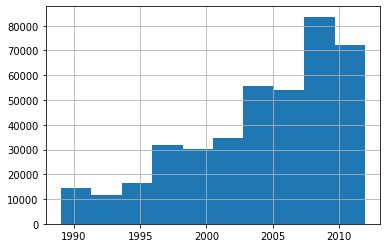

In [122]:
xs['saleYear'].hist()

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push